In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Compare greedy vs epsilon-greedy for 10-arm testbed

In [2]:
# rewrite with everything inside the class
class Bandit():
    def __init__(self, n = 10, epsilon = 0, q0 = 0, alpha = 0.1):
        self.n = n
        self.q = np.random.normal(0,1,n)
        self.best_action = np.argmax(self.q)
        self.action_count = np.ones(n)
        self.action_value = np.zeros(n) + q0
        self.epsilon = epsilon
        self.alpha = alpha
        self.step = 1 # assume the first step is 1
        self.c = 2 # exploration parameter for UCB
    
    def select_action_epsilon_greedy(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.n)
        else:
            return np.argmax(self.action_value)
    
    def selection_action_ucb(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.n)
        else:
            ucb = self.action_value + self.c * np.sqrt(np.log(self.step) / self.action_count)
        return np.argmax(ucb)
    
    def update(self, action, reward):
        self.action_count[action] += 1
        self.action_value[action] += (reward - self.action_value[action]) / self.action_count[action]
        
    def update_ewma(self, action, reward):
        self.action_count[action] += 1
        self.action_value[action] += self.alpha * (reward - self.action_value[action])

    def simulate_bandit(self, steps, ucb = False, ewma = False):
        rewards = np.zeros(steps)
        optimal_action = np.zeros(steps)
        for step in range(1,steps+1):
            if ucb: # use UCB
                action = self.selection_action_ucb()
                reward = np.random.normal(self.q[action], 1)
            else: # use epsilon-greedy
                action = self.select_action_epsilon_greedy()
                reward = np.random.normal(self.q[action], 1)
            if ewma:
                self.update_ewma(action, reward)
            else:
                self.update(action, reward)
            if action == self.best_action:
                optimal_action[step-1] = 1
            rewards[step-1] = reward
            self.step += 1
        return rewards, optimal_action


In [3]:
# simulate the bandit problem
number_of_runs = 2000
number_of_steps = 1000
epsilons = [0, 0.01, 0.1]
# Initialize arrays to store average rewards and optimal actions for each epsilon
avg_rewards = np.zeros((len(epsilons), number_of_steps))
avg_optimal_actions = np.zeros((len(epsilons), number_of_steps))
# Loop over each epsilon
for i, epsilon in enumerate(epsilons):
    # Loop over each run
    for j in tqdm(range(number_of_runs), desc=f"Epsilon: {epsilon}", colour='green'):
        np.random.seed(j)
        # Initialize bandit with current epsilon
        if i == 0:
            bandit = Bandit(epsilon=epsilon, q0 = 5)
            rewards, optimal_actions = bandit.simulate_bandit(number_of_steps, ucb = False)
        else:
            bandit = Bandit(epsilon=epsilon)
            rewards, optimal_actions = bandit.simulate_bandit(number_of_steps, ucb = True)
        # Update average rewards and optimal actions
        avg_rewards[i] += (rewards - avg_rewards[i]) / (j + 1)
        avg_optimal_actions[i] += (optimal_actions - avg_optimal_actions[i]) / (j + 1)

Epsilon: 0.1: 100%|██████████| 2000/2000 [00:08<00:00, 240.47it/s]


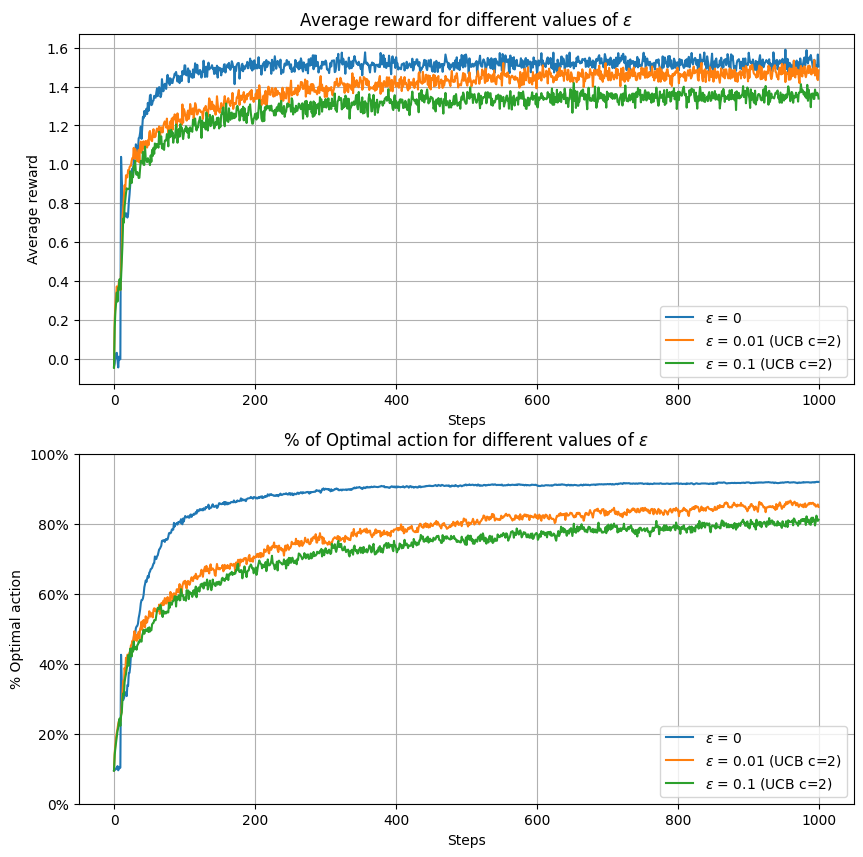

In [4]:
# Plot the results
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
for i, epsilon in enumerate(epsilons):
    plt.plot(avg_rewards[i], label=f'$\epsilon$ = {epsilon if i == 0 else str(epsilon) + " (UCB c=2)"}')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.grid()
plt.legend()
plt.title('Average reward for different values of $\epsilon$')
plt.subplot(2, 1, 2)
for i, epsilon in enumerate(epsilons):
    plt.plot(avg_optimal_actions[i], label=f'$\epsilon$ = {epsilon if i == 0 else str(epsilon) + " (UCB c=2)"}')
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.grid()
plt.legend()
plt.title('% of Optimal action for different values of $\epsilon$')
plt.show()



## Non-Stationary Bandit
three algorithms are used
- Epsilon-greedy with updating action-value using sample average
- Epsilon-greedy with updating action-value using EWMA (eponentially weighted moving average )

In [6]:
class Non_Stationary_Bandit(Bandit):
    def __init__(self, sigma=0.01, n=10, epsilon=0, q0=0, alpha=0.1):
        super().__init__(n, epsilon, q0, alpha)
        self.sigma = 0.01
    
    def update_q(self):
        self.q += np.random.normal(0, self.sigma, self.n)
        self.best_action = np.argmax(self.q)

    def simulate_non_stationary_bandit(self, steps, ewma = False):
        rewards = np.zeros(steps)
        optimal_action = np.zeros(steps)
        for step in range(1,steps+1):
            action = self.select_action_epsilon_greedy()
            reward = np.random.normal(self.q[action], 1)
            if ewma:
                self.update_ewma(action, reward)
            else:
                self.update(action, reward)
            if action == self.best_action:
                optimal_action[step-1] = 1
            rewards[step-1] = reward
            self.update_q()
        return rewards, optimal_action

In [7]:
# simulate with 2 strategies, sample average vs EWMA
number_of_runs = 2000
number_of_steps = 10000
labels = ['epsilon-greedy (sample average)', 'epsilon-greedy (EWMA)']
avg_rewards = np.zeros((len(labels), number_of_steps))
avg_optimal_actions = np.zeros((len(labels), number_of_steps))
for i in range(len(labels)):
    if i == 0: # epsilon-greedy with sample average
        ewma = False
    else: # epsilon-greedy with ewma
        ewma = True
    for j in tqdm(range(number_of_runs), desc=f"Bandit: {labels[i]}", colour='green'):
        bandit = Non_Stationary_Bandit(epsilon=0.1, alpha=0.1) # initialize bandit
        rewards, optimal_actions = bandit.simulate_non_stationary_bandit(number_of_steps, ewma)
        avg_rewards[i] += (rewards - avg_rewards[i]) / (j + 1) # update average rewards
        avg_optimal_actions[i] += (optimal_actions - avg_optimal_actions[i]) / (j + 1)

Bandit: epsilon-greedy (EWMA): 100%|██████████| 2000/2000 [01:11<00:00, 28.08it/s]


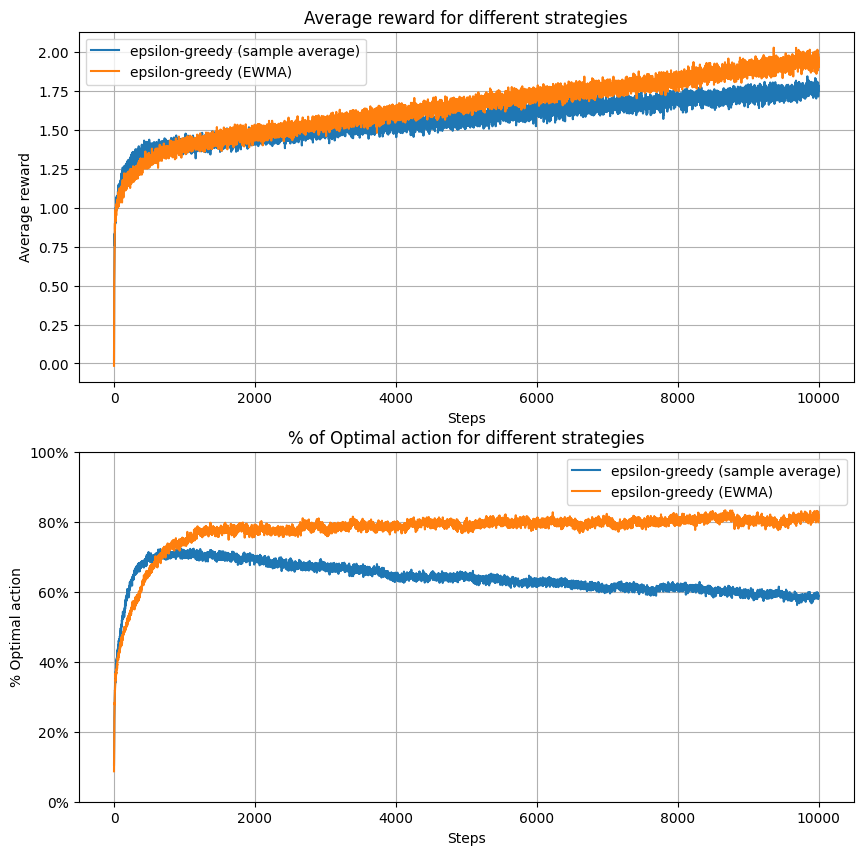

In [8]:
# plot the results
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
for i, label in enumerate(labels):
    plt.plot(avg_rewards[i], label=label)
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.grid()
plt.legend()
plt.title('Average reward for different strategies')
plt.subplot(2, 1, 2)
for i, label in enumerate(labels):
    plt.plot(avg_optimal_actions[i], label=label)
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.grid()
plt.legend()
plt.title('% of Optimal action for different strategies')
plt.show()


### Conclusion
In a non-stationary setting described by the project, we can clearly see that the naive sample average method perform worse than than EWMA method with $\alpha=0.1$, where EWMA has the ability to give more weight to recent rewards than to older ones. This characteristic makes EWMA particularly well-suited for environments where the reward distributions of the actions change over time.
- The sample average method keep maximizing average reward, however the proportional of optimal action decrease after roughly 1000 steps as the enviornment keep constantly evovling, it fail to capture the best action.
- The sample average perform better at the beginning, faster growth of average reward and proportional of optimal action, but then start to underperform as steps evovle.